In [1]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.optim as optim
import torchvision.transforms as transforms
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from PIL import Image
from tqdm import tqdm
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", None)
np.random.seed(42)

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [2]:
import sys
sys.path.append('./BGR')
import bgr.soil.datasets as bgr_data
import bgr.soil.models as bgr_mod
from bgr.soil.callbacks import EarlyStopping

In [3]:
path_csv = "../data/BGR/data_horizons.csv"
path_csv_annotator_ids = '../data/BGR/Kartierer_ID.csv'
path_csv_locations = '../data/BGR/STANDORT.csv'
path_horizons_simple = '../data/BGR/Vereinfachung_Horizontsymbole.csv'
#path_pictures = "/Users/felix/Library/CloudStorage/Dropbox/data/BGR-Data-Bodenhorizonte/Profilbilder/"
path_pictures = "../data/BGR/Profilbilder_no_ruler_no_sky/"

In [4]:
df = pd.read_csv(path_csv)
print(len(df.index))
df = df.dropna(subset=['Horizontsymbol'])
print(len(df.index))
df#.head()

15207
15206


,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_simple = pd.read_csv(path_horizons_simple)
df_simple.rename(columns={"relevanter Anteil = was sinntragend und detektierbar ist - es sind nicht alles gültige Symbole": "relevanter Anteil"}, inplace=True)
df_simple.head()

,Horiz,Anzahl im Datensatz,relevanter Anteil,stark vereinfacht
0,Ap,1762,Ap,Ap
1,Bv,626,Bv,Bv
2,ilCv,620,ilC,Cv
3,elCv,500,elC,Cv
4,Ah,455,Ah,Ah


In [6]:
# Add an extra column to the original dataset with the simplified horizon symbols

# Apply the simplification function to each row of the 'Horizontsymbol' column
col_name = "relevanter Anteil" # try to predict 'relevanter Anteil' first; otherwise, resort to 'stark vereinfacht'
df['Horizontsymbol_relevant'] = df['Horizontsymbol'].apply(lambda x: bgr_data.simplify_string(x, df_simple, col_name))

# Reorder the columns
cols = df.columns.tolist()
cols.insert(cols.index('Horizontsymbol') + 1, 'Horizontsymbol_relevant')
cols.pop() # remove the duplicate at the end
df = df[cols]
df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0
4,2.0,5.0,96.0,201.0,III; ilCv,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15201,6211.0,3.0,27.0,50.0,I; Bbh+Bs,Bbh+Bs,fSms,5YR 3/2,1.0,C0,h2,Wf3,NaN,NaN,NaN,NaN,NaN,NaN
15202,6211.0,4.0,50.0,70.0,I; Bbs+Bs,Bbs+Bs,fSms,5YR 4/3,1.0,C0,h1,Wf2,NaN,NaN,NaN,NaN,NaN,NaN
15203,6211.0,5.0,70.0,100.0,I; Go-Bbs,Go-Bbs,fSms,7.5YR 5/4,1.0,C0,h1,Wf6,NaN,NaN,NaN,NaN,NaN,NaN
15204,6211.0,6.0,100.0,130.0,I; Go,Go,fSms,2.5Y 6/4,1.0,C0,h0,Wf4,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
image_dataset = os.listdir(path_pictures)
img_files = pd.DataFrame(image_dataset, columns=['file'])
img_files['Point'] = img_files['file'].str.split("_").map(lambda x: x[1]).astype(float)
img_files.head()

,file,Point
0,BB_0896_Y_1.JPG,896.0
1,BB_0903_Y_1.JPG,903.0
2,BW_4930_Y_1.JPG,4930.0
3,BW_5183_Y_1.JPG,5183.0
4,BW_5462_Y_1.JPG,5462.0


In [8]:
for img in img_files['file']:
    if len(img.split('_')) < 2:
        print(img)

In [9]:
df = pd.merge(df, img_files, how='inner', on='Point')
df['file'] = df['file'].map(lambda x: os.path.join(path_pictures, x))
df.head()

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland,PointID,Unnamed: 14,profile,max_depth,file
0,2.0,1.0,0.0,28.0,I; Ap,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,NaN,SH,2.0,NaN,BB_0541.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
1,2.0,2.0,28.0,54.0,I; E,E,Sl2,10YR 3/3,3.0,C0,h2,Wf3,NaN,SH,3.0,NaN,BB_0600.0,90.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
2,2.0,3.0,54.0,68.0,II; Bv,Bv,Sl2,7.5YR 4/3,10.0,C0,h1,Wf3,NaN,SH,4.0,NaN,BB_0601.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
3,2.0,4.0,68.0,96.0,III; Bv-ilCv,Bv-ilC,fSms,7.5YR 6/4,1.0,C0,h0,Wf2,NaN,SH,5.0,NaN,BB_0659.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...
4,2.0,5.0,96.0,201.0,III; ilCv,ilC,mSfs,10YR 7/4,1.0,C0,h0,NaN,NaN,SH,6.0,NaN,BB_0660.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...


In [10]:
df_k = pd.read_csv(path_csv_annotator_ids)
df_k = df_k.rename({'PointID':'Point'},axis=1)
df_k.head()

,Point,Aufnehmer
0,2,Kart8
1,3,Kart8
2,4,Kart10
3,5,Kart8
4,6,Kart8


In [11]:
df_loc = pd.read_csv(path_csv_locations, encoding='unicode_escape')
df_loc = df_loc.rename({'PointID':'Point'},axis=1)
df_loc.head()

,Point,Bundesland,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2,SH,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,>200,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,3,SH,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,4,SH,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,5,SH,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,6,SH,10,2015,505020.3377,6080401.37,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35


In [12]:
df = pd.merge(df, df_k, how='inner', on='Point')

In [13]:
df_loc['Point'] = pd.to_numeric(df['Point'])
df = pd.merge(df, df_loc, how='inner', on='Point')

In [14]:
df[df['ycoord']=='N0'] # invalid ycoord?

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,Unnamed: 11,Bundesland_x,PointID,Unnamed: 14,profile,max_depth,file,Aufnehmer,Bundesland_y,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
693,23.0,1.0,0.0,32.0,I; Ap,Ap,Sl4,10YR 3/3,3.0,C0,h3,Wf3,NaN,MV,148.0,NaN,BB_1264.0,90.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
699,23.0,2.0,32.0,42.0,I; Ap+Al,Ap+Al,Sl4,10YR 4/3,4.0,C0,h1,Wf2,NaN,MV,149.0,NaN,BB_1265.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
705,23.0,3.0,42.0,54.0,I; Bt-Swd,Bt-Sd,Ls3,10YR 5/4,4.0,C0,h1,Wf1,NaN,MV,150.0,NaN,BB_1266.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
711,23.0,4.0,54.0,74.0,I; Sd1,Sd1,Ls3,10YR 5/6,4.0,C0,h0,Wf1,NaN,SH,151.0,NaN,BB_1267.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
717,23.0,5.0,74.0,100.0,I; Sd2,Sd2,Ls3,2.5Y 5/4,5.0,C0,h0,Wf1,NaN,SH,152.0,NaN,BB_1317.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
723,23.0,6.0,100.0,201.0,II; Sd-ilCv,Sd-ilC,Lt2,NaN,2.0,C0,h0,NaN,NaN,SH,153.0,NaN,BB_1318.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,GWS3,120,0,0.0,N0,NaN,GG,TS,Z,159.95,118.85,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4119,172.0,1.0,0.0,33.0,I; Ap,Ap,Sl2,10YR 3/2,3.0,C0,h3,Wf4,NaN,ST,1183.0,NaN,BY_4419.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/MV_01...,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4123,172.0,2.0,33.0,53.0,I; Sw,Sw,Sl2,10YR 5/4,3.0,C0,h0,Wf2,NaN,ST,1185.0,NaN,BY_4425.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/MV_01...,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4127,172.0,3.0,53.0,120.0,I; Swd,Sd,Sl3,2.5Y 5/4,3.0,C0,h0,NaN,NaN,BB,1186.0,NaN,BY_4427.0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/MV_01...,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4131,172.0,4.0,120.0,201.0,II; eSd,Sd,Sl4,2.5Y 5/4,3.0,C3.3,h0,NaN,NaN,BB,1187.0,NaN,BY_4428.0,70.0,../data/BGR/Profilbilder_no_ruler_no_sky/MV_01...,Kart8,GWS4,110,42,24.0,N0,NaN,GG,TS,Z,251.99,84.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df = df[df['ycoord'] != 'N0']
len(df)

17629

In [16]:
keep_columns = ['Point', 'HorizontID', 'Obergrenze', 'Untergrenze',
                #'Horizontsymbol',
                'Horizontsymbol_relevant', 'Bodenart', 'Bodenfarbe', 'Steine', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung',
                'max_depth', 'file', 'Aufnehmer', 'Probenahme_Monat', 'Probenahme_Jahr', 'xcoord', 'ycoord', 'Bodenklimaraum_Name',
                'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'BodenVarTypSub', 'GrundwaStufe', 'GrundwaStand', 'Moormaechtigkeit',
                'Torfmaechtigkeit', 'Neigung', 'Exposition', 'Woelbung', 'Reliefformtyp', 'LageImRelief', 'KV_0_30', 'KV_30_100']

df = df[keep_columns]

df['GrundwaStand'] = df['GrundwaStand'].str.replace('>','').astype(float)
#df['xcoord'] = df['xcoord'].str.replace(',','.').astype(float)
#df['ycoord'] = df['ycoord'].str.replace(',','.').astype(float)
#df['ycoord'] = df['ycoord'].str.replace('N0','0').astype(float)
#df['KV_0_30'] = df['KV_0_30'].str.replace(',','.').astype(float)
#df['KV_30_100'] = df['KV_30_100'].str.replace(',','.').astype(float)

df

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Aufnehmer,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
0,2.0,1.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,11,2015,462216.1283,6079359.775,Marsch - Nord,A,0,YE,YE/BB,0,200.0,0.0,0.0,N0,NaN,GG,V,Z,81.89,54.19
1,2.0,1.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,6,2016,480546.9384,6079739.216,Marsch - Nord,G,0,MD,MDn,GWS4,135.0,0.0,0.0,N0,NaN,GG,TSF,Z,71.62,59.74
2,2.0,1.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,8,2018,484922.3074,6080011.471,Marsch - Nord,A,0,MK,MKn,GWS4,105.0,0.0,0.0,N1,NE,GG,TH,Z,65.60,120.40
3,2.0,1.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,10,2015,497355.9905,6079646.589,Marsch - Nord,G,0,RQ,p2RQ/GG-PP,GWS4,180.0,0.0,0.0,N0.2,SS,GG,KSF,K,88.82,220.87
4,2.0,1.0,0.0,28.0,Ap,Sl2,7.5YR 3/2,3.0,C0,h3,Wf4,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,10,2015,505020.3377,6080401.37,Geest - Nord,G,0,YU,aGGe-YU,GWS4,140.0,0.0,0.0,N0,NaN,GG,TSF,Z,62.97,84.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17634,1059.0,5.0,70.0,105.0,Gr,Su2,10YR 6/2,0.0,C0,h0,Wf0,NaN,../data/BGR/Profilbilder_no_ruler_no_sky/ST_10...,Kart9,3,2012,384409.7401,5456592.806,Mittellagen Rheinland-Pfalz und Saarland,A,0,RZ,SS-RZ,0,200.0,0.0,0.0,N3,NW,XX,H,O,80.52,25.30
17635,1059.0,5.0,70.0,105.0,Gr,Su2,10YR 6/2,0.0,C0,h0,Wf0,NaN,../data/BGR/Profilbilder_no_ruler_no_sky/ST_10...,Kart9,2,2012,437827.5634,5454050.546,Rheinebene und Nebentäler,SO,0,YY,YYn,0,200.0,0.0,0.0,N1,SS,XX,KSF,Z,58.43,52.27
17636,1059.0,5.0,70.0,105.0,Gr,Su2,10YR 6/2,0.0,C0,h0,Wf0,NaN,../data/BGR/Profilbilder_no_ruler_no_sky/ST_10...,Kart9,10,2011,448236.4426,5454486.16,Rheinebene und Nebentäler,A,0,TC,vLL-TC,0,200.0,0.0,0.0,N0.1,NaN,XX,V,Z,37.83,41.80
17637,1059.0,5.0,70.0,105.0,Gr,Su2,10YR 6/2,0.0,C0,h0,Wf0,NaN,../data/BGR/Profilbilder_no_ruler_no_sky/ST_10...,Kart9,11,2011,450265.8395,5448367.068,Rheinebene und Nebentäler,A,0,YK,YKn,0,200.0,0.0,0.0,N1,EE,XV,T,Z,38.99,47.26


In [17]:
# Profile images only show horizons up to ~1 meter depth
df = df[df['Obergrenze'] <= 100]
len(df)

14251

In [18]:
# TODO: What's a good imputation strategy? There are lots of NaNs...
df = df.dropna()
len(df)

4908

In [19]:
min_labels = 100#10
target = 'Horizontsymbol_relevant'
num_features   = ['xcoord','ycoord', 'Steine', 'Probenahme_Monat', 'Probenahme_Jahr', 'GrundwaStand', 'Moormaechtigkeit', 'Torfmaechtigkeit', 'KV_0_30', 'KV_30_100']
categ_features = ['Bodenart', 'Bodenfarbe', 'Karbonat', 'Humusgehaltsklasse', 'Durchwurzelung', 'Bodenklimaraum_Name',
                  'Landnutzung', 'BZE_Moor', 'Hauptbodentyp', 'BodenVarTypSub', 'GrundwaStufe', 'Neigung',
                  'Exposition', # there's a problem with this feature, leading to CUDA errors during training
                  'Woelbung', 'Reliefformtyp', 'LageImRelief']
feature_columns = num_features + categ_features

vision_backbone = 'WinKawaks/vit-small-patch16-224'

/tmp/ipykernel_40221/4155449390.py:6: MatplotlibDeprecationWarning: Support for passing numbers through unit converters is deprecated since 3.5 and support will be removed two minor releases later; use Axis.convert_units instead.
  plt.xticks([])


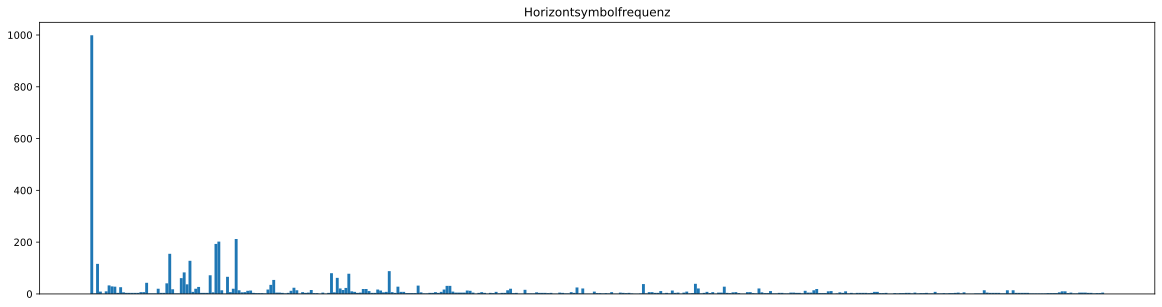

In [20]:
counts = df[target].value_counts()
plt.figure(figsize=(20, 5))
plt.hist(df[target], bins = np.arange(len(counts))-0.5)
plt.title('Horizontsymbolfrequenz')
#plt.xticks(rotation='vertical')
plt.xticks([])
plt.show()

In [21]:
counts

Horizontsymbol_relevant
Ap           999
Ah           212
Sw           202
Sd           193
Go           155
            ... 
Bv+Bbt         1
Sd-Bt1         1
Bv+Ael-Sw      1
Ael-Sw         1
R+eSwd1        1
Name: count, Length: 352, dtype: int64

In [22]:
# Filter out for most frequent symbols
keep_horiz_symb = counts[(900 > counts) & (counts >= 100)].index
#keep_horiz_symb = counts[counts >= 100].index
keep_horiz_symb

Index(['Ah', 'Sw', 'Sd', 'Go', 'tGo', 'Bv'], dtype='object', name='Horizontsymbol_relevant')

In [23]:
df = df[df['Horizontsymbol_relevant'].isin(keep_horiz_symb)]
len(df)

1006

In [24]:
# Encode label vector
bgr_data.encode_categorical_columns(df, target)
df[target] = df[target].astype(int)

/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))


In [25]:
for categ in categ_features:
    bgr_data.encode_categorical_columns(df, categ)
df

/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[col_name] = df[col_name].replace(counts.index, range(len(counts)))
/mnt/KInsektDaten/teo/./BGR/bgr/soil/datasets.py:35: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly ca

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Aufnehmer,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
12,2.0,3.0,54.0,68.0,5,2,31,10.0,0,1,4,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,8,2018,484922.3074,6080011.471,37,0,0,28,197,1,105.0,0.0,0.0,0,2,0,3,1,65.60,120.40
13,2.0,3.0,54.0,68.0,5,2,31,10.0,0,1,4,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,10,2015,497355.9905,6079646.589,37,1,0,10,257,1,180.0,0.0,0.0,3,1,0,11,5,88.82,220.87
349,11.0,3.0,27.0,52.0,3,5,16,0.0,0,1,0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,9,2016,569598.3543,6035155.469,13,1,0,3,8,0,200.0,0.0,0.0,1,6,2,0,0,85.40,40.48
350,11.0,3.0,27.0,52.0,3,5,16,0.0,0,1,0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,5,2016,576862.9588,6034047.818,13,0,0,1,12,0,200.0,0.0,0.0,2,4,0,0,0,40.62,20.12
352,11.0,3.0,27.0,52.0,3,5,16,0.0,0,1,0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,8,2017,647378.3872,6036771.889,13,0,0,2,1,0,200.0,0.0,0.0,3,1,0,2,1,68.53,19.07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16141,879.0,1.0,0.0,10.0,0,9,2,0.0,0,3,2,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/MV_08...,Kart8,8,2013,706245.5104,5301523.549,33,1,0,0,0,0,200.0,0.0,0.0,4,1,2,0,2,61.10,26.30
16156,879.0,4.0,54.0,105.0,3,6,4,0.0,0,0,0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/MV_08...,Kart8,8,2013,706245.5104,5301523.549,33,1,0,0,0,0,200.0,0.0,0.0,4,1,2,0,2,61.10,26.30
16300,918.0,1.0,0.0,13.0,0,16,0,0.0,0,2,2,60.0,../data/BGR/Profilbilder_no_ruler_no_sky/HB_09...,Kart8,3,2015,401423.6732,5277964.361,36,1,0,3,268,0,200.0,0.0,0.0,5,7,6,0,2,104.87,55.08
16303,918.0,1.0,0.0,13.0,0,16,0,0.0,0,2,2,60.0,../data/BGR/Profilbilder_no_ruler_no_sky/HB_09...,Kart8,6,2015,500791.6926,5281348.993,43,1,0,3,5,0,200.0,0.0,0.0,7,4,0,0,4,58.95,37.38


In [26]:
# Define the image normalization
normalize = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]), # Normalize with ImageNet statistics
])

In [27]:
# Initialize model
model = bgr_mod.ImageTabularModel(vision_backbone=vision_backbone,
                                  num_tabular_features=len(feature_columns),
                                  num_classes=len(df[target].unique()))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at WinKawaks/vit-small-patch16-224 were not used when initializing ViTModel: ['classifier.bias', 'classifier.weight']
- This IS expected if you are initializing ViTModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTModel were not initialized from the model checkpoint at WinKawaks/vit-small-patch16-224 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImageTabularModel(
  (vision_backbone): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0): ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=384, out_features=384, bias=True)
              (key): Linear(in_features=384, out_features=384, bias=True)
              (value): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=384, out_features=384, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=384, 

In [28]:
# Data split
train_df, val_df = train_test_split(df, stratify=df[target], random_state=2024)

print(f'{len(train_df)} samples for training.')
print(f'{len(val_df)} samples for validating.')

754 samples for training.
252 samples for validating.


In [29]:
# Define the image transforms for augmentation
augment = [
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.GaussianBlur(kernel_size=(33, 33), sigma=(2., 5.))
]

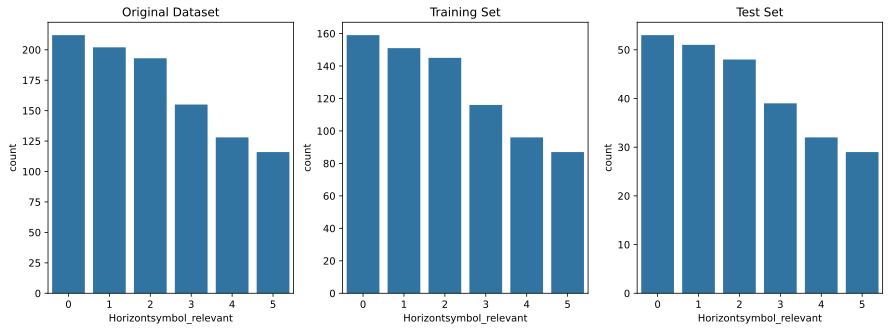

In [30]:
# Visualize the distributions
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.countplot(x=target, data=df, ax=axes[0])
axes[0].set_title('Original Dataset'); #axes[0].set_xticklabels([])

sns.countplot(x=target, data=train_df, ax=axes[1])
axes[1].set_title('Training Set'); #axes[1].set_xticklabels([])

sns.countplot(x=target, data=val_df, ax=axes[2])
axes[2].set_title('Test Set'); #axes[2].set_xticklabels([])

plt.show()

In [31]:
# Erstelle das Dataset mit DataFrame, Bildern und tabellarischen Daten
train_dataset = bgr_data.ImageTabularDataset(dataframe=train_df,#[:100],
                                       normalize=normalize,
                                       augment=augment,
                                       image_path='file',
                                       label=target,
                                       feature_columns=feature_columns)

# Erstelle den DataLoader
train_loader = DataLoader(train_dataset, batch_size=64,#16,
                          shuffle=True, num_workers=8)

# Beispiel: Definiere einen Optimizer und eine Loss-Funktion
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

In [32]:
### Callbacks
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, threshold=1e-2, min_lr=1e-5, verbose=True)
early_stopping = EarlyStopping(patience=5, min_delta=0.01, verbose=True)

In [33]:
len(train_dataset.dataframe)

754

In [34]:
len(train_dataset)

2262

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image 0: Tabular Features [851151.9375, 5827347.0, 3.0, 8.0, 2017.0, 200.0, 0.0, 0.0, 42.36000061035156, 13.800000190734863, 4.0, 9.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 7.0, 92.0, 0.0, 0.0, 3.0, 0.0, 3.0, 1.0] | Label 2
Image 1: Tabular Features [851151.9375, 5827347.0, 3.0, 8.0, 2017.0, 200.0, 0.0, 0.0, 42.36000061035156, 13.800000190734863, 4.0, 9.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 7.0, 92.0, 0.0, 0.0, 3.0, 0.0, 3.0, 1.0] | Label 2
Image 2: Tabular Features [851151.9375, 5827347.0, 3.0, 8.0, 2017.0, 200.0, 0.0, 0.0, 42.36000061035156, 13.800000190734863, 4.0, 9.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 7.0, 92.0, 0.0, 0.0, 3.0, 0.0, 3.0, 1.0] | Label 2


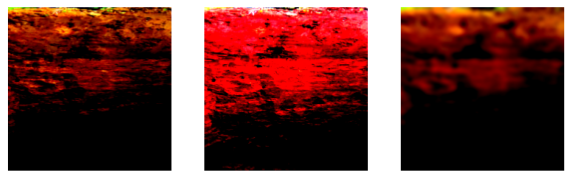

In [35]:
# Check an augmented subset
aug_images = []
for i in range(len(train_dataset)):
    image, tabular_features, label = train_dataset[i]
    aug_images.append(image)
    print(f"Image {i}: Tabular Features {tabular_features.tolist()} | Label {label.item()}")
    if i == 2: break

plt.figure(figsize=(10, 8))
for i in range(len(aug_images)):
    plt.subplot(1, 3, i+1)
    plt.imshow(aug_images[i].swapaxes(0,2).swapaxes(0,1)) # returned shape is (c, h, w)
    plt.axis('off')

In [36]:
val_dataset = bgr_data.ImageTabularDataset(dataframe=val_df,#[:100],
                                            normalize=normalize,
                                            image_path='file',
                                            label=target,
                                            feature_columns=feature_columns)

# Erstelle den DataLoader
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=8)

In [37]:
len(val_dataset)

252

In [38]:
len(val_dataset.dataframe)

252

In [39]:
val_dataset.dataframe

,Point,HorizontID,Obergrenze,Untergrenze,Horizontsymbol_relevant,Bodenart,Bodenfarbe,Steine,Karbonat,Humusgehaltsklasse,Durchwurzelung,max_depth,file,Aufnehmer,Probenahme_Monat,Probenahme_Jahr,xcoord,ycoord,Bodenklimaraum_Name,Landnutzung,BZE_Moor,Hauptbodentyp,BodenVarTypSub,GrundwaStufe,GrundwaStand,Moormaechtigkeit,Torfmaechtigkeit,Neigung,Exposition,Woelbung,Reliefformtyp,LageImRelief,KV_0_30,KV_30_100
5927,263.0,1.0,0.0,10.0,0,16,0,0.0,0,3,2,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_02...,Kart10,11,2016,755412.9504,5773300.813,1,0,0,7,76,0,200.0,0.0,0.0,1,5,2,3,1,26.83,8.32
9321,435.0,3.0,28.0,50.0,4,8,20,0.0,0,1,4,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/NI_04...,Kart8,10,2015,597130.1804,5648619.426,4,1,0,4,3,0,200.0,0.0,0.0,2,1,0,0,0,111.24,21.52
9333,435.0,3.0,28.0,50.0,4,8,20,0.0,0,1,4,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/NI_04...,Kart8,10,2015,597130.1804,5648619.426,4,1,0,4,3,0,200.0,0.0,0.0,2,1,0,0,0,111.24,21.52
2511,89.0,3.0,52.0,97.0,2,17,12,3.0,0,0,0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,5,2012,736013.4302,5933833.438,5,1,0,0,2,0,200.0,0.0,0.0,0,0,1,0,1,43.63,16.80
13574,692.0,4.0,68.0,125.0,3,8,10,0.0,0,1,6,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/NI_06...,Kart9,10,2015,597879.3476,5417513.17,6,0,0,2,19,0,200.0,0.0,0.0,0,0,0,0,4,81.46,50.86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14541,750.0,2.0,30.0,110.0,3,22,3,3.0,0,0,0,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/NI_07...,Kart9,11,2014,682793.7762,5377584.318,10,1,0,0,2,0,200.0,0.0,0.0,5,3,5,0,2,58.71,25.85
1678,60.0,2.0,10.0,20.0,4,8,17,0.0,0,2,5,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/SH_00...,Kart8,4,2012,697020.0301,5961504.452,0,0,0,0,231,4,135.0,0.0,0.0,3,1,2,16,5,43.35,14.71
7110,325.0,4.0,49.0,74.0,3,10,9,1.0,0,0,3,100.0,../data/BGR/Profilbilder_no_ruler_no_sky/MV_03...,Kart4,4,2013,357400.5842,5719180.888,14,0,0,0,52,5,150.0,0.0,0.0,0,0,0,13,1,89.30,27.12
14177,724.0,2.0,30.0,66.0,2,4,36,6.0,4,0,0,90.0,../data/BGR/Profilbilder_no_ruler_no_sky/MV_07...,Kart5,10,2013,714242.6864,5395165.328,10,0,0,2,4,0,200.0,0.0,0.0,5,1,5,0,3,48.77,17.48


In [40]:
model.train()
epochs = 10
lr_history, train_loss_history, train_acc_history, val_loss_history, val_acc_history = [], [], [], [], []
for epoch in range(epochs):
    print(f"Epoch {epoch + 1}/{epochs}")
    # Training loop
    train_correct = 0
    train_loss_total = 0
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for batch in train_loader_tqdm:
        images, tabular_features, labels = batch
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        optimizer.zero_grad() # otherwise, PyTorch accumulates the gradients during backprop
        outputs = model(image=images, tabular_features=tabular_features)
        train_loss = criterion(outputs, labels)
        train_loss.backward()
        optimizer.step()

        # Calculate accuracy for this batch
        train_loss_total += train_loss.item()
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()

        train_loader_tqdm.set_postfix(loss=train_loss.item())

    # Calculate average training accuracy for the epoch
    train_acc = train_correct / len(train_loader.dataset)
    avg_train_loss = train_loss_total / len(train_loader)

    # Evaluation loop
    model.eval()
    val_correct = 0
    val_loss_total = 0
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    with torch.no_grad():
        for batch in val_loader_tqdm:
            images, tabular_features, labels = batch
            images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
            outputs = model(image=images, tabular_features=tabular_features)
            val_loss = criterion(outputs, labels)

            val_loss_total += val_loss.item()
            _, predicted = torch.max(outputs.data, 1)
            val_correct += (predicted == labels).sum().item()

    # Calculate average val accuracy for the epoch
    val_acc = val_correct / len(val_loader.dataset)
    avg_val_loss = val_loss_total / len(val_loader)

    # Apply the scheduler with validation loss
    scheduler.step(avg_val_loss)
    # Log the current learning rate
    current_lr = optimizer.param_groups[0]['lr']
    lr_history.append(current_lr)
    # Log metrics
    train_loss_history.append(avg_train_loss); val_loss_history.append(avg_val_loss)
    train_acc_history.append(train_acc); val_acc_history.append(val_acc)

    print(f"Epoch {epoch+1}, Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_acc:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    print(f"Current LR: {current_lr}")

    # Early stopping check
    early_stopping(val_loss)
    if early_stopping.should_stop:
        print(f"Early stopping at epoch {epoch+1}")
        break

Epoch 1/10


Epoch 1, Training Loss: 1.7260, Training Accuracy: 0.2555, Test Loss: 1.6564, Test Accuracy: 0.2698
Current LR: 0.001
Epoch 2/10


Epoch 2, Training Loss: 1.7305, Training Accuracy: 0.2710, Test Loss: 1.6135, Test Accuracy: 0.3532
Current LR: 0.001
EarlyStopping: No improvement for 1 epochs.
Epoch 3/10


Epoch 3, Training Loss: 1.5766, Training Accuracy: 0.3364, Test Loss: 1.4932, Test Accuracy: 0.3968
Current LR: 0.001
Epoch 4/10


Epoch 4, Training Loss: 1.5565, Training Accuracy: 0.3475, Test Loss: 1.4442, Test Accuracy: 0.4246
Current LR: 0.001
EarlyStopping: No improvement for 1 epochs.
Epoch 5/10


Epoch 5, Training Loss: 1.4279, Training Accuracy: 0.3966, Test Loss: 1.3738, Test Accuracy: 0.4206
Current LR: 0.001
EarlyStopping: No improvement for 2 epochs.
Epoch 6/10


Epoch 6, Training Loss: 1.3920, Training Accuracy: 0.4235, Test Loss: 1.3871, Test Accuracy: 0.4127
Current LR: 0.001
EarlyStopping: No improvement for 3 epochs.
Epoch 7/10


Epoch 7, Training Loss: 1.3350, Training Accuracy: 0.4434, Test Loss: 1.2849, Test Accuracy: 0.4921
Current LR: 0.001
Epoch 8/10


Epoch 8, Training Loss: 1.2597, Training Accuracy: 0.4783, Test Loss: 1.2360, Test Accuracy: 0.4484
Current LR: 0.001
Epoch 9/10


Epoch 9, Training Loss: 1.1855, Training Accuracy: 0.5066, Test Loss: 1.2066, Test Accuracy: 0.4841
Current LR: 0.001
Epoch 10/10


Epoch 10, Training Loss: 1.1614, Training Accuracy: 0.5296, Test Loss: 1.0749, Test Accuracy: 0.5437
Current LR: 0.001


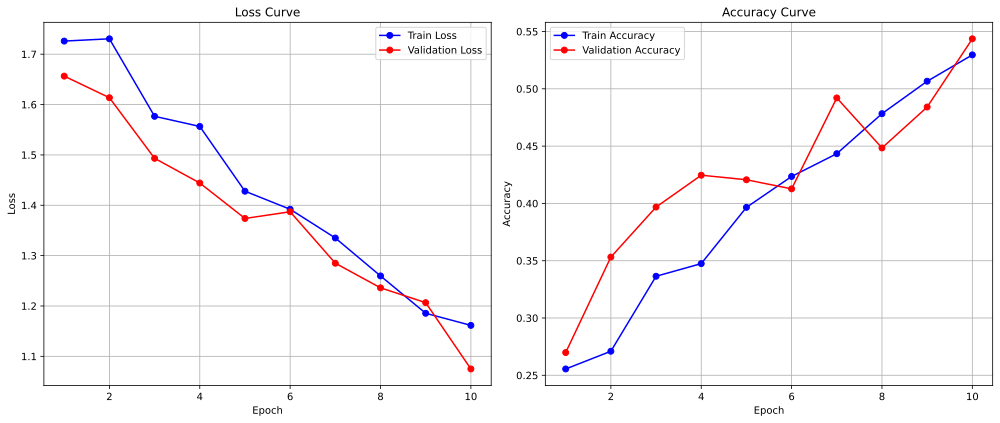

In [41]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_loss_history, label='Train Loss', marker='o', color='b')
plt.plot(range(1, epochs + 1), val_loss_history,  label='Validation Loss',  marker='o', color='r')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), train_acc_history, label='Train Accuracy', marker='o', color='b')
plt.plot(range(1, epochs + 1), val_acc_history, label='Validation Accuracy', marker='o', color='r')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

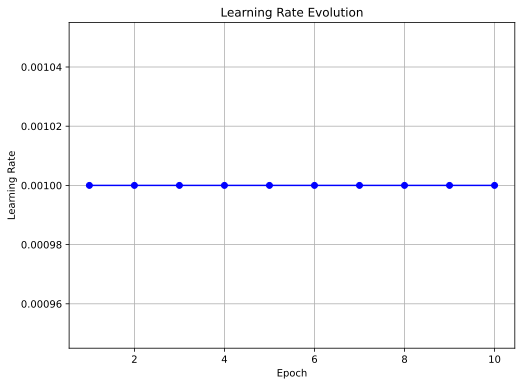

In [42]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, epochs + 1), lr_history, marker='o', linestyle='-', color='b')
plt.title("Learning Rate Evolution")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.grid()
plt.show()

In [43]:
model.eval()  # Setze das Modell in den Evaluierungsmodus
with torch.no_grad():
    outputs = []
    val_loader_tqdm = tqdm(val_loader, desc="Evaluating", leave=False)
    for batch in val_loader_tqdm:
        images, tabular_features, labels = batch
        images, tabular_features, labels = images.to(device), tabular_features.to(device), labels.to(device)
        outputs.append(model(image=images, tabular_features=tabular_features))

In [71]:
from sklearn.metrics import classification_report, confusion_matrix

# Convert outputs to predicted labels (adjust based on your model's output format)
predicted_probs, predicted_labels = [], []
for output in outputs:

    predicted_labels.extend(torch.argmax(output, dim=1).tolist())
    predicted_probs.extend(torch.softmax(output, dim=1).cpu().numpy()) # Convert logits to probabilities

# Convert true labels to a list
true_labels = [label.item() for batch in val_loader for label in batch[2]]

# Calculate metrics
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.24      0.28      0.26        53
           1       0.27      0.16      0.20        51
           2       0.26      0.17      0.20        48
           3       0.16      0.18      0.17        39
           4       0.13      0.16      0.14        32
           5       0.11      0.17      0.14        29

    accuracy                           0.19       252
   macro avg       0.19      0.19      0.18       252
weighted avg       0.21      0.19      0.19       252



In [74]:
# Compute PR curve for each class
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize

predicted_probs = np.array(predicted_probs)
true_labels = np.array(true_labels)
n_classes = predicted_probs.shape[1]
precision, recall, avg_precision = {}, {}, {}
# Binarize the labels (one-hot encoding for multiclass)
true_labels_binarized = label_binarize(true_labels, classes=np.arange(n_classes))

for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(true_labels_binarized[:, i], predicted_probs[:, i])
    avg_precision[i] = average_precision_score(true_labels_binarized[:, i], predicted_probs[:, i])

# Compute macro-average PR curve
precision["macro"], recall["macro"], _ = precision_recall_curve(true_labels_binarized.ravel(), predicted_probs.ravel())
avg_precision["macro"] = average_precision_score(true_labels_binarized, predicted_probs, average="macro")

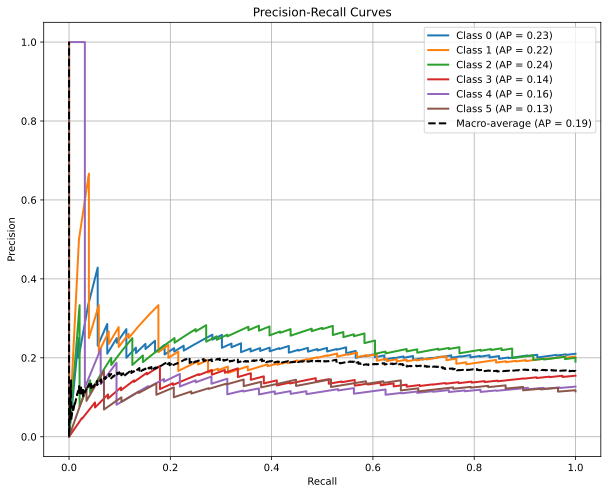

In [76]:
plt.figure(figsize=(10, 8))

# Plot PR curves for each class
for i in range(n_classes):
    plt.plot(recall[i], precision[i], lw=2, label=f'Class {i} (AP = {avg_precision[i]:.2f})')

# Plot macro-average PR curve
plt.plot(recall["macro"], precision["macro"], linestyle='--', lw=2, color='black',
         label=f'Macro-average (AP = {avg_precision["macro"]:.2f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend(loc='upper right')
plt.grid()
plt.show()

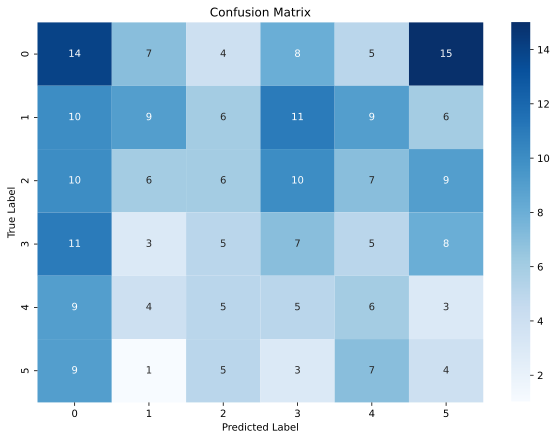

In [45]:
cm = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [46]:
"""
# TODO
from transformers import TrainingArguments, Trainer

# Define training arguments
training_args = TrainingArguments(
    output_dir="./testtest",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    evaluation_strategy="epoch",
    num_train_epochs=53,
    logging_dir="./logs",
    logging_steps=10,
    save_steps=1000,
    learning_rate=5e-5,
    weight_decay=0.01,
    report_to="none",  # Set to "wandb" or other service if tracking experiments
)

# Initialize the Trainer with the model, data, and training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    data_collator=collate_fn,
)

# Train the model
trainer.train()

# Evaluate the model on the test dataset
eval_results = trainer.evaluate()
print(f"Test Accuracy: {eval_results['eval_accuracy']}")
"""

'\n# TODO\nfrom transformers import TrainingArguments, Trainer\n\n# Define training arguments\ntraining_args = TrainingArguments(\n    output_dir="./testtest",\n    per_device_train_batch_size=32,\n    per_device_eval_batch_size=32,\n    evaluation_strategy="epoch",\n    num_train_epochs=53,\n    logging_dir="./logs",\n    logging_steps=10,\n    save_steps=1000,\n    learning_rate=5e-5,\n    weight_decay=0.01,\n    report_to="none",  # Set to "wandb" or other service if tracking experiments\n)\n\n# Initialize the Trainer with the model, data, and training arguments\ntrainer = Trainer(\n    model=model,\n    args=training_args,\n    train_dataset=train_dataset,\n    eval_dataset=test_dataset,\n    data_collator=collate_fn,\n)\n\n# Train the model\ntrainer.train()\n\n# Evaluate the model on the test dataset\neval_results = trainer.evaluate()\nprint(f"Test Accuracy: {eval_results[\'eval_accuracy\']}")\n'